# Introduction (UNDER REVISION)

A decision tree is a simple, easy to interpret modeling technique for both regression and classification problems. Decision trees usually do not perform very well compared to other methods. Their relevance lies in the fact that they are the building blocks of two of the most successful ML algorithms as per today: random forests and gradient boosted trees. In this chapter, we will introduce these tree-based methods.

# Decision Trees

## How they work

In our journey to estimate the model $f$ by $\hat f$, we have considered mainly linear functions $f$ so far. We now move to a different function class: decision trees. They have been introduced in 1984 by Leo Breiman, Jerome Friedman and others [1] and are sometimes called "Classification and Regression Trees" (CART). 

(Binary) decision trees are calculated recursively by partitioning the data in two pieces. Partitions are chosen to optimize the given loss by asking the best "yes/no" question about the covariates, e.g., "is carat < 1?" or "is color better than F?".

Typical loss functions (= "objectives") are the MSE for regression problems and information (= cross-entropy = log loss = logistic deviance) or Gini impurity for classification. The latter can be viewed as a "variance" for categorical variables.

Predictions are calculated by sending an observation through the tree, starting with the question at the "trunk" and ending in a "leaf". The prediction is the value associated with the leaf. For MSE loss, the leaf values equal the average response of all observations in the leaf. In classification settings, it may be the most frequent class in the leaf or all class probabilities.

The concept of a decision tree is best understood with an example.

## Example: decision tree

We will use the `dataCar` data set to predict the claim probability with a decision tree. As features, we use `veh_value`, `veh_body`, `veh_age`, `gender`, `area` and `agecat`.

In [11]:
import pandas as pd
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

# Load data
car = pd.read_csv("car.csv")  # see readme how to get the data

# Feature groups
num_vars = ["veh_value", "veh_age", "agecat"]
ord_vars = ["gender", "area", "veh_body"]
all_vars = num_vars + ord_vars  # Use same order in preprocessor

# Prepare feature matrix. To easily plot the resulting tree with feature names,
# we avoid dummy encodings here for simplicity.
preprocessor = make_column_transformer(
    ("passthrough", num_vars),
    (OrdinalEncoder(), ord_vars)
)
X = preprocessor.fit_transform(car)
pd.DataFrame(X, columns=all_vars).head()  # Okay?

,veh_value,veh_age,agecat,gender,area,veh_body
0,1.06,3.0,2.0,0.0,2.0,3.0
1,1.03,2.0,4.0,0.0,0.0,3.0
2,3.26,2.0,2.0,0.0,4.0,12.0
3,4.14,2.0,2.0,0.0,3.0,10.0
4,0.72,4.0,2.0,0.0,2.0,3.0


In [8]:
# Fit model
model = DecisionTreeClassifier(criterion="entropy", max_depth=3)
model.fit(X, car["clm"])

DecisionTreeClassifier(criterion='entropy', max_depth=3)

In [17]:
model.predict_proba(X[[0]])

array([[0.9333264, 0.0666736]])

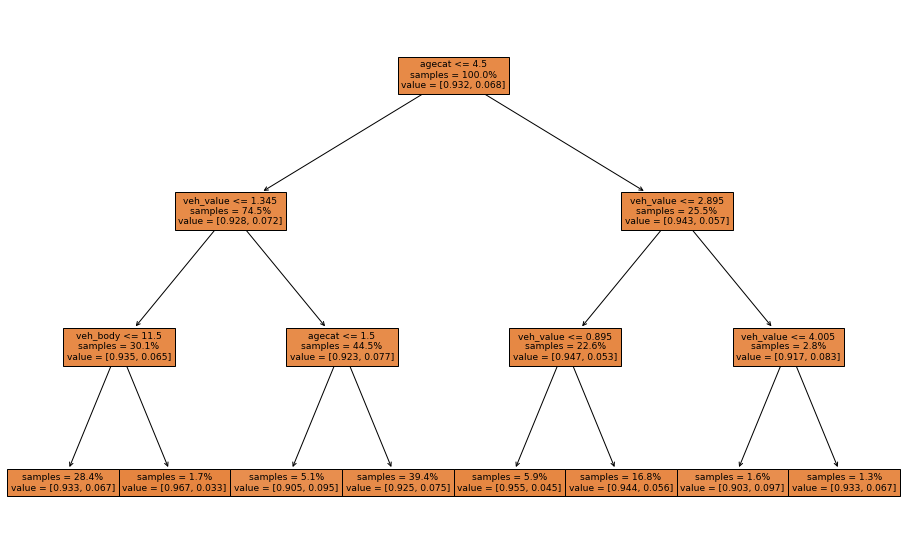

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 10))
_ = tree.plot_tree(model,
                   feature_names=all_vars, proportion=True,
                   filled=True, impurity=False)

**Comments**

- The first observation belongs to a person in age category 2 and has a $10'600 hatchback: the first question sends us to the right, the second to the left and the third to the right. This gives us a claim probability of 6.7%.
- How was, e.g., the first question (`agecat >= 5`) chosen? The algorithm scans all covariates for all possible split positions and picks the one with best loss improvement. In this case, splitting on covariate `agecat` at the value 5 reduced the loss most.

**Properties of decision trees**

- **Outliers:** In contrast to linear models, outliers in covariates are not an issue because the algorithm only takes into account the sort order of the values. Similarly, taking logarithms in covariates has no effect. Both statements do not hold for the response variable.
- **Missing values:** Some implementations can deal with missing values in the input. Alternatively, missing values are often replaced by a typical value or a value smaller/larger than the smallest non-missing value (such as -1 for a positive variable).
- **Categorical covariates:** Unordered categorical covariates are tricky to split because with $\ell$ levels, theoretically, we end up with $2^\ell$ possible partitions. Try to lump small categories together or consider representing the levels by ordered categories (even if it does not make too much sense). One-hot-encoding is an option as well. Some algorithms offer ways to internally deal with unordered categoricals.
- **Greedy:** Partitions are made in a greedy way to optimize the objective in *one step*. Looking ahead more than one step would lead to better models but this is computationally too demanding in practice.
- **Interactions:** By their flexible structure, a decision tree can automatically capture interaction effects of any order (and other non-linear effects), at least if the data set is large and the tree is deep enough. This is a big advantage of tree-based methods compared to linear models where these elements have to carefully and manually be accounted for. In the next chapter, we will meet another model class with this advantage: neural nets.
- **Extrapolation:** By construction, a decision tree cannot extrapolate. So even a whopping 10 carat diamond cannot get a higher price prediction than the most expensive diamond in the training data.

These properties typically translate 1:1 to combinations of trees like random forests or boosted trees.

# Random Forests

## How they work

In 2001, Leo Breiman introduced a very powerful tree-based algorithm called *random forest*, see [2]. A random forest consists of many decision trees. To ensure that the trees differ, two sources or randomness are injected:

1. Each split scans only a random selection "mtry" of the $m$ covariates to find the best split, usually about $\sqrt{m}$ or $m/3$. "mtry" is the main tuning parameter of a random forest.
2. Each tree is calculated on a bootstrap sample of the data, i.e., on $n$ observations selected with replacement from the original $n$ rows. This technique is called "bagging", from "**b**ootstrap **agg**regat**ing**". 

Predictions are found by pooling the predictions of all trees, e.g., by averaging or majority voting.

**Comments about random forests**

- **Number of trees:** Usually, 100-1000 trees are being grown. The more, the better. More trees also mean longer training time and larger models.
- **Diversification:** Single trees in a random forest are usually very deep. They overfit on the training data. It is the diversity across trees that produces a good and stable model, just with a well-diversified stock portfolio. 
- **Never trust performance on the training set for random forests.**
- **OOB validation**: In each tree, about 1/3 of all observations are not in the bootstrap sample just by chance. Put differently: each observation is used in about 2/3 of all trees. If its prediction is calculated from the other 1/3 of the trees, we get an "out-of-sample" prediction, also called "out-of-bag" (OOB) prediction. If rows are independent, model performance derived from these OOB predictions is usually good enough to be used for model validation. Do not use OOB results when rows are dependent such as for grouped samples.
- **Parameter tuning:** Random forests offer many tuning parameters. Since the results typically do not depend too much on their choice, untuned random forests are often great benchmark models.

## Example: random forest

Let us now fit a random forest for diamond prices with typical parameters and 500 trees. 80% of the data is used for training, the other 20% we use for evaluating the performance. We use stratified splitting on the response variable. (Throughout the rest of the lecture, we will ignore the problematic aspect of having repeated rows for some diamonds.)

**Comments**

- Performance is excellent.
- The OOB estimate of performance is extremely close to the test set performance.
- Interpretation?

## Interpreting a "black box"

In contrast to a single decision tree or a linear model, a combination of many trees is not easy to interpret. It is good practice for any ML model to study at least *variable importance* and the strongest *effects*, not just its performance. A pure prediction machine is hardly of any interest and might even contain mistakes like using covariates derived from the response. Model interpretation helps to fight such problems and thus also to increase trust in a model.

### Variable importance

There are different approaches to measure the importance of a covariate. Since there is no general mathematical definition of "importance", the results of different approaches might be inconsistent across each other. For tree-based methods, a usual approach is to measure how many times a covariate $X$ was used in a split or how much loss improvement came from splitting on $X$.

Approaches that work for *any* supervised model (including neural nets) include **permutation importance** and **SHAP importance**.

### Effects

One of the main reasons for the success of modern methods like random forests is the fact that they automatically learn interactions between two or more covariates. Thus, the effect of a covariate $X$ typically depends on the values of other covariates. In the extreme case, the effect of $X$ is different for each observation. The best what we can do is to study the *average effect* of $X$ over many observations, i.e., averaging the effects over interactions. This leads us to **partial dependence plots**: They work for any supervised ML model and are constructed as follows: A couple of observations are selected. Then, their average prediction is visualized against $X$ when sliding their value of $X$ over a reasonable grid of values, *keeping all other variables fixed*. The more natural the Ceteris Paribus clause, the more reliable the partial dependence plots.

Remark: A partial dependence plot of a covariate in a linear regression is simply a visualization of its coefficient.

Alternatives to partial dependence plots include **accumulated local effect plots** and **SHAP dependence plots**. Both relax the Ceteris Paribus clause.

## Example: random forest (continued)

For our last example, we will now look at variable importance and partial dependence plots.

**Comments**

- As expected, `carat` is the most important predictor.
- All effects as assessed by partial dependence make sense.

## Exercises

1. In above example, replace carat by its logarithm. Do the results change compared to the example without logs?
2. Fit a random forest on the claims data, predicting the binary variable `clm` by the covariates `veh_value`, `veh_body`, `veh_age`, `gender`, `area`, and `agecat`. Choose a suitable tree-depth by maximizing OOB error on the training data. Make sure to fit a *probability random forest*, i.e., predicting probabilities, not classes. Additionally, make sure to work with a relevant loss function (information/cross-entropy or Gini gain). Use a simple train/test split. Interpret the results by split gain importance and partial dependence plots.

# Gradient Boosted Trees

The idea of *boosting* was introduced by Schapire in 1990 [3] and roughly works as follows: A simple model is fit to the data. Then, another simple model is added, trying to correct the errors from the first model. This process is repeated until some stopping criterion triggers. As simple models or *base learners*, usually **small decision trees** are used, an idea pushed by Jerome Friedman in his famous 2001 article on the very general framework of gradient boosting machines [4]. 

Modern variants of such *gradient boosted trees* are [XGBoost](https://xgboost.readthedocs.io/en/latest/), [LightGBM](https://lightgbm.readthedocs.io/en/latest/) and [CatBoost](https://catboost.ai/). These are the predominant algorithms in ML competitions on tabular data, check [this comparison](https://github.com/mayer79/gradient_boosting_comparison) for differences with a screenshot as per Sept. 25, 2020:

<img src="../figs/comparison_boosting.PNG" width="40%">

Predictions are calculated similar to random forests, i.e., by combining predictions of all trees. As loss/objective function, one can choose among many possibilities. Often, using the same loss as a corresponding GLM is a good choice.

## Example: XGBoost (untuned)

As an initial example on gradient boosting and XGBoost, we fit a model for diamond prices with MSE loss. The number of rounds/trees is chosen by early stopping on the validation data, i.e. until validation RMSE stops improving for a couple or rounds. The learning rate (weight of each tree) is chosen by trial and error in order to end up with a reasonably small/large number of trees, see the next section for more details.

**Comments:** 

- More trees would mean better training performance, but worse validation performance.
- Compared to simple validation, cross-validation would provide an even better way to find the optimal number of boosting rounds/trees.
- In the next example, we will show how to interpret such model.

## Parameters of gradient boosted trees

Gradient boosted trees offer a quite a lot of parameters. Unlike with random forests, they need to be tuned to achieve good results. It would be naive to use an algorithm like XGBoost without parameter tuning. Here is a selection:

- **Number of boosting rounds:** In contrast to random forests, more trees/rounds is not always beneficial because the model begins to overfit after some time. The optimal number of rounds is usually found by early stopping, i.e., one lets the algorithm stop as soon as the (cross-)validation performance stops improving, see the example above.

- **Learning rate:** The learning rate determines training speed and the impact of each tree to the final model. Typical values are between 0.01 and 0.5. In practical applications, it is set to a value that leads to a reasonable amount of trees (100-1000). Usually, halving the learning rate means twice as much boosting rounds for comparable performance.

- **Regularization parameters:** Depending on the implementation, additional parameters are
    - the tree depth (often 3-7) or the number of leaves (often 7-63), 
    - the strength of the L1 and/or L2 penalties added to the loss function (often between 0 and 5), 
    - the row subsampling rate (often between 0.8 and 1), 
    - the column subsampling rate (often between 0.6 and 1), 
    - ...
  
  Reasonable regularization parameters are chosen by trial and error or systematically by randomized or grid search CV. Usually, it takes a couple of iterations until the range of the parameter values have been set appropriately.

Note on tuning: Since learning rate, number of boosting rounds and regularization parameters are heavily interdependent, a "big" randomized grid search CV to choose learning rate, boosting rounds and regularization is often not ideal. Above suggestion (fix learning rate, select number of rounds by early stopping and do grid search only on regularization parameters) is more focussed, see also the example below.

Note on **evaluation metrics**: While loss/objective functions are used by the algorithm to *fit* the model, an evaluation metric is a function used to monitor performance, tune parameters and select models. Ideally, it is consistent with the loss function of the specific algorithm (for instance RMSE as metric and MSE as loss), but in some cases it might differ.
For classification, besides studying (multi-)log loss, e.g., one sometimes considers the *confusion matrix* and its derived measures like accuracy, precision, recall, F1-score etc.  [Wikipedia](https://en.wikipedia.org/wiki/Confusion_matrix) summarizes these concepts. The confusion matrix tabulates the combinations of actual classes and predicted classes. Note that such measures derived from the confusion matrix do not enjoy good statistical properties and focussing on them might lead to suboptimal models.

## Example: XGBoost (tuned)

We will use XGBoost to fit diamond prices using MSE as loss function and evaluation metric, now using a sophisticated tuning strategy.

Overall, the tuning strategy is as follows:

1. Using default regularization parameters, set the learning rate to get reasonable number of trees with CV-based early stopping.
2. Iterate randomized search CV to tune regularization parameters such as tree depth.
3. Use the best parameter combination to fit the model on the training data.

Now, the model is ready to be inspected by evaluating 

- its test performance, 
- by looking at gain importance and 
- a couple of partial dependence plots.

**Comment**: The resulting model seems comparable to the random forest with slightly better performance.

## Exercises

1. Study the online documentation of XGBoost to figure out how to make the model monotonically increasing in carat. Test your insights without rerunning the grid search in our last example, i.e., just be refitting the final model. How does the partial dependence plot for `carat` look now?
2. Develop a strong XGBoost model for the claims data set with binary response `clm` and covariates `veh_value`, `veh_body`, `veh_age`, `gender`, `area`, and `agecat`. Use a clean cross-validation/test approach. Use log loss both as objective and evaluation metric. Interpret its results.

# Chapter Summary

In this chapter, we have met decision trees, random forests and tree boosting. Single decision trees are very easy to interpret but do not perform too well. On the other hand, tree ensembles like the random forest or gradient boosted trees usually perform very well but are tricky to interpret. We have introduced interpretation tools to look into such "black boxes". The main reason why random forests and boosted trees often provide more accurate models than a linear model lies in their ability to automatically learn interactions and other non-linear effects.

# Chapter References

[1] L. Breiman, J. Friedman, R. Olshen, and C. Stone, "Classification and Regression Trees", Wadsworth, Belmont, CA, 1984.

[2] L. Breiman, "Random forests". In: Machine Learning, 2001, 45(1).

[3] R. Schapire, "The strength of weak learnability", Machine Learning, Vol 5, Nr. 2, 1990.

[4] J. Friedman, "Greedy Function Approximation: A Gradient Boosting Machine", 2001.

In [25]:
from plotnine.data import diamonds

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.inspection import PartialDependenceDisplay

# Ordered categoricals to be integer encoded in correct order
ord_vars = ["color", "cut", "clarity"]
ord_levels = [
    diamonds[x].cat.categories.to_list() for x in ord_vars
]

# Modeling
model = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("linear", "passthrough", ["carat"]),
            ("ordered", OrdinalEncoder(categories=ord_levels), ord_vars)
        ],
    ),
    RandomForestRegressor(max_features="sqrt", min_samples_leaf=5)
)

model.fit(diamonds, y=diamonds["price"])

PartialDependenceDisplay.from_estimator(
    model,
    diamonds, 
    n_jobs=8,
    features=["carat"] + ord_vars,
    custom_values=dict(zip(ord_vars, ord_levels))
)